<a href="https://colab.research.google.com/github/unninakul/meat-quality-assessment/blob/main/Assignment_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Data Preprocessing and Image Conversion
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [ ]:
#Image Conversion
import os
from PIL import Image

In [ ]:
# Function to convert images and replace them
def convert_images(folder_path):
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, file_name)

            try:
                image = Image.open(file_path)
            except Exception as e:
                print(f"Error opening {file_name}: {str(e)}")
                continue

            new_file_path = os.path.splitext(file_path)[0] + ".jpg"

            try:
                image.save(new_file_path, "JPEG")
            except Exception as e:
                print(f"Error converting {file_name} to JPEG: {str(e)}")
                continue

            os.remove(file_path)
            os.rename(new_file_path, file_path)
            print(f"{file_name} converted to JPEG and replaced successfully.")

In [ ]:
folder_path = "/content/drive/MyDrive/meat/meat"

In [ ]:
# Convert images in beef dataset folder
convert_images(folder_path)

In [ ]:
# Importing Dataset
dataset_beef = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 959 files belonging to 9 classes.


In [ ]:
# Data Preperation
for image_batch, label_batch in dataset_beef.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[8 8 7 1 6 8 8 5 7 4 3 0 1 6 6 1 3 4 8 4 6 6 3 7 5 0 3 0 3 8 7 7]


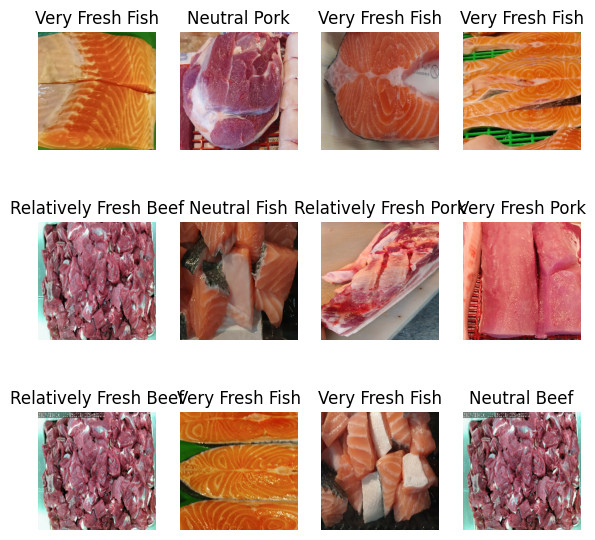

In [ ]:
# Data Exploration
plt.figure(figsize=(7, 7))
for image_batch, label_batch in dataset_beef.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        class_names = ['Neutral Beef', 'Neutral Fish', 'Neutral Pork','Relatively Fresh Beef', 'Relatively Fresh Fish','Relatively Fresh Pork','Very Fresh Beef','Very Fresh Fish', 'Very Fresh Pork']
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
# Define a function to get dataset partitions
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,
                              shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds_beef, val_ds_beef, test_ds_beef = get_dataset_partitions_tf(dataset_beef)
print(len(train_ds_beef), len(val_ds_beef), len(test_ds_beef))

24 3 3


In [ ]:
# Preprocessing Images
import tensorflow as tf
from tensorflow.keras import layers,models
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.Rescaling(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
# Define the CNN Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(None, *input_shape))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(patience=3)

In [ ]:
# Training the Model
history = model.fit(
    train_ds_beef,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds_beef
)


Epoch 1/30
24/24 [==============================] - 294s 7s/step - loss: 2.1165 - accuracy: 0.2021 - val_loss: 1.8669 - val_accuracy: 0.3958
Epoch 2/30
24/24 [==============================] - 181s 7s/step - loss: 1.7569 - accuracy: 0.3233 - val_loss: 1.6646 - val_accuracy: 0.3229
Epoch 3/30
24/24 [==============================] - 178s 7s/step - loss: 1.5402 - accuracy: 0.3246 - val_loss: 1.4863 - val_accuracy: 0.3229
Epoch 4/30
24/24 [==============================] - 177s 7s/step - loss: 1.4122 - accuracy: 0.4211 - val_loss: 1.2494 - val_accuracy: 0.4167
Epoch 5/30
24/24 [==============================] - 166s 6s/step - loss: 1.3213 - accuracy: 0.4420 - val_loss: 1.1310 - val_accuracy: 0.4688
Epoch 6/30
24/24 [==============================] - 179s 7s/step - loss: 1.2059 - accuracy: 0.4263 - val_loss: 1.5995 - val_accuracy: 0.4167
Epoch 7/30
24/24 [==============================] - 177s 7s/step - loss: 1.1559 - accuracy: 0.4720 - val_loss: 1.1492 - val_accuracy: 0.4688
Epoch 8/30
24

In [ ]:
# Testing the Model
scores = model.evaluate(test_ds_beef)
print(scores)

3/3 [==============================] - 26s 1s/step - loss: 0.9796 - accuracy: 0.5521
[0.9796392917633057, 0.5520833134651184]


In [ ]:
# For Evaluation of Model
print(history.params)
print(history.history.keys())
print(history.history['accuracy'])
print(len(history.history['accuracy']))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

{'verbose': 1, 'epochs': 30, 'steps': 24}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.20208604633808136, 0.3233376741409302, 0.32464146614074707, 0.4211212396621704, 0.4419817328453064, 0.4263363778591156, 0.47196871042251587, 0.4354628324508667, 0.4485006630420685, 0.48239895701408386, 0.46284225583076477, 0.49674054980278015, 0.4550195634365082, 0.48239895701408386, 0.48761409521102905, 0.4641460180282593, 0.48500651121139526, 0.4934895932674408, 0.5045632123947144, 0.48370274901390076, 0.5019556879997253, 0.5280312895774841, 0.5149934887886047, 0.4986979067325592, 0.5019556879997253, 0.5006518959999084, 0.49152541160583496, 0.5097783803939819, 0.5228161811828613, 0.4921875]
30


Text(0.5, 1.0, 'Training And Validation Accuracy')

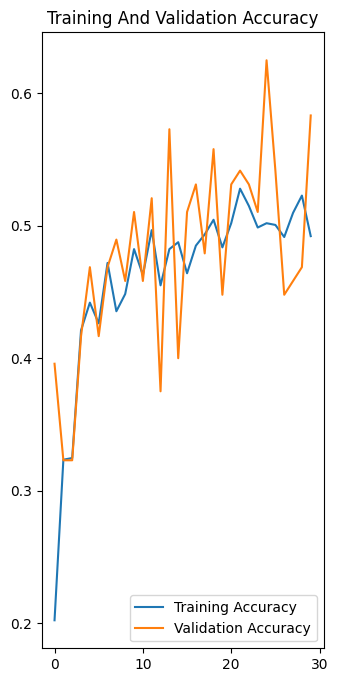

In [ ]:
# Training & Validation accuracy evaluation
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training And Validation Accuracy')

First image to predict


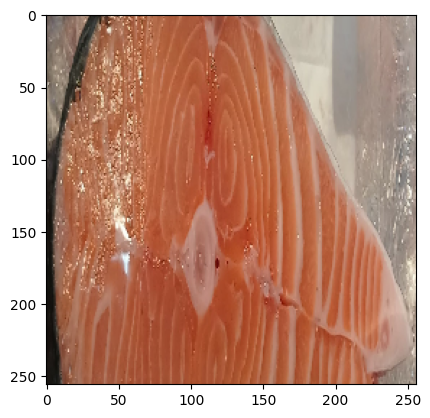

Actual label: Very Fresh Fish
1/1 [==============================] - 1s 1s/step
Predicted Label: Very Fresh Fish


In [ ]:
# Prediction
for images_batch, labels_batch in test_ds_beef.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    plt.show()  # Display the image

    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    predicted_label_index = np.argmax(batch_prediction[0])

    print("Predicted Label:", class_names[predicted_label_index])